# SVM with Cira

### Cira

In [1]:
import cira

In [2]:
cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [3]:
import pandas as pd 

In [4]:
from datetime import datetime

IS_CACHED = True 
SYMBOL = "MSFT"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not IS_CACHED:
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,MSFT,54.41,55.23,54.30,55.22,39952779.0,194807.0,54.877235
2015-12-02 05:00:00+00:00,MSFT,55.32,55.96,55.06,55.21,47274879.0,225980.0,55.484361
2015-12-03 05:00:00+00:00,MSFT,55.49,55.77,53.93,54.20,38627835.0,219413.0,54.475820
2015-12-04 05:00:00+00:00,MSFT,54.12,56.23,54.10,55.91,43963662.0,232021.0,55.540921
2015-12-07 05:00:00+00:00,MSFT,55.79,55.97,55.29,55.81,30709765.0,182309.0,55.623798


<Axes: xlabel='timestamp'>

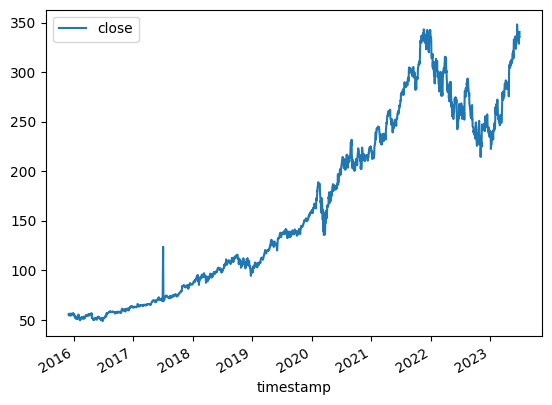

In [5]:
data.plot.line(y="close", use_index=True)

### SVM

In [6]:
from sklearn.svm import SVR

In [7]:
train_data = data.iloc[:int(len(data)*0.8)]
test_data =  data.iloc[int(len(data)*0.8):]
print(len(data), len(train_data), len(test_data))

X = train_data[["open", "high", "low"]]
y = train_data['close']

X_test = test_data[["open", "high", "low"]]
y_test = test_data["close"] 

1908 1526 382


In [8]:
model = SVR()
model = model.fit(X, y)

In [9]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("mean squared error: ", mse)
len(predictions), len(y_test)

mean squared error:  491.4293286241161


(382, 382)

Text(0.5, 1.0, 'predictions vs reality')

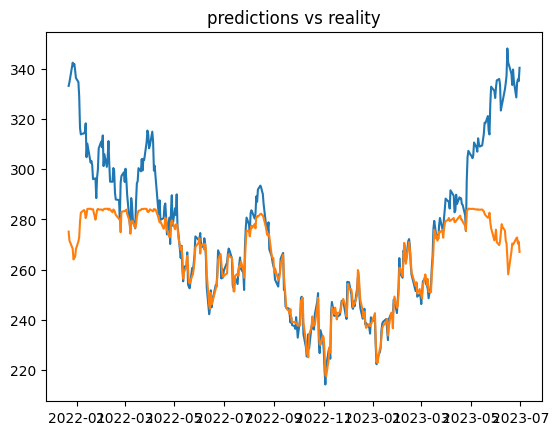

In [10]:
import matplotlib.pyplot as plt

plt.plot(X_test.index, y_test)
plt.plot(X_test.index, predictions)
plt.title("predictions vs reality")


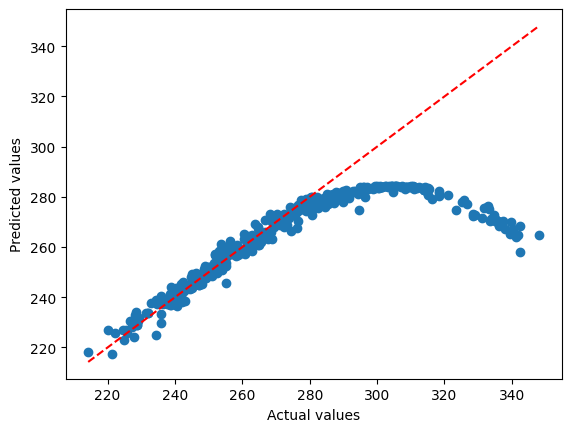

In [11]:

plt.scatter(y_test, predictions)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.show()

### Cira Backtest

In [12]:
from cira.backtest import model_vs_buy_and_hold 
from cira.sizer import PositionSizer

['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']

In [14]:

from typing import List
from cira.strategy import Strategy
import numpy as np


class SvmStrat(Strategy):
    def __init__(self, initial_capital=10_000, risk=0.1, threshold=0.1, stop_loss=100, max_pos_size=100) -> None:
        self.capital = initial_capital
        self.asset_count = 0

        self.model = SVR()
        self.features = ["open", "high", "low"]
        self.target = "close"
        self.sizer = PositionSizer(risk_percentage=risk, stop_loss_price=stop_loss, max_position_size=max_pos_size)

        self.risk = risk
        self.threshold = threshold
        self.stop_loss = stop_loss
        self.max_pos_size = max_pos_size
 
    def fit(self, train_data) -> None:
        X_train = train_data[self.features]
        y_train = train_data[self.target]
        self.model.fit(X_train, y_train)

    def predict(self, data:np.ndarray) -> np.ndarray: 
        return self.model.predict(data[self.features])

    def size(self, entry_price:float, predictions:np.ndarray, current_position:int, cash:float) -> int:
        self.capital = cash 
        sig = predictions[-1] - entry_price > self.threshold
        return self.sizer.size(self.capital, entry_price=entry_price, current_position=current_position, is_buy_signal=sig)

    def get_features_names(self) -> List[str]:
        return self.features

diff: 1.1539567308194678
model profit: 17059$


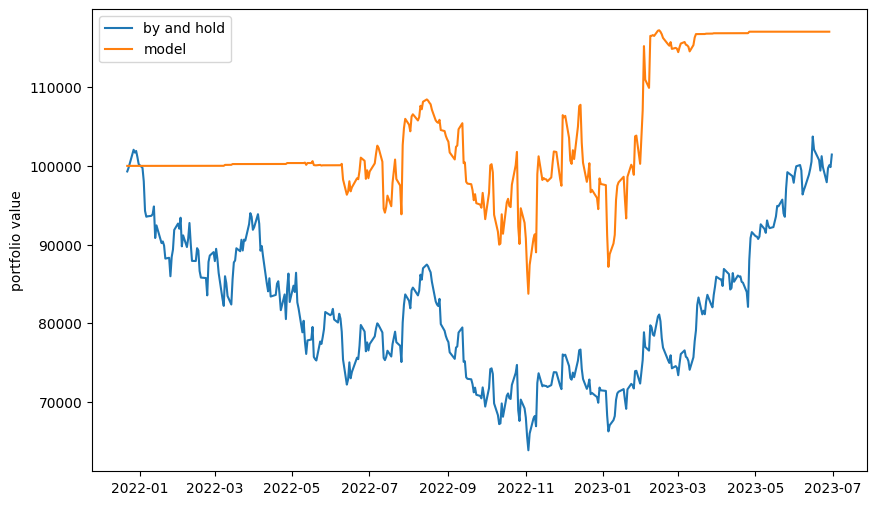

In [15]:

INITIAL_CAPITAL = 100_000.0
THRESHOLD = 0.1
RISK = 0.003

STOP_LOSS = test_data["close"].values[0] * 0.8
MAX_POS_SIZE = 10


strat = SvmStrat(initial_capital=INITIAL_CAPITAL, risk=RISK, threshold=THRESHOLD, stop_loss=STOP_LOSS, max_pos_size=MAX_POS_SIZE)

strat.fit(train_data=train_data)


bh, res = model_vs_buy_and_hold(strat, test_data, capital=INITIAL_CAPITAL, use_fees=True)


bh_end = bh["capital"].values[-1]
model_end = res['capital'].values[-1]

print(f"diff: {model_end / bh_end}")
print(f"model profit: {int(model_end - INITIAL_CAPITAL)}$")

plt.figure(figsize=(10,6))
plt.plot(bh.index, bh["capital"], label="by and hold")
plt.plot(res.index, res["capital"], label="model")
plt.ylabel("portfolio value")
plt.legend()


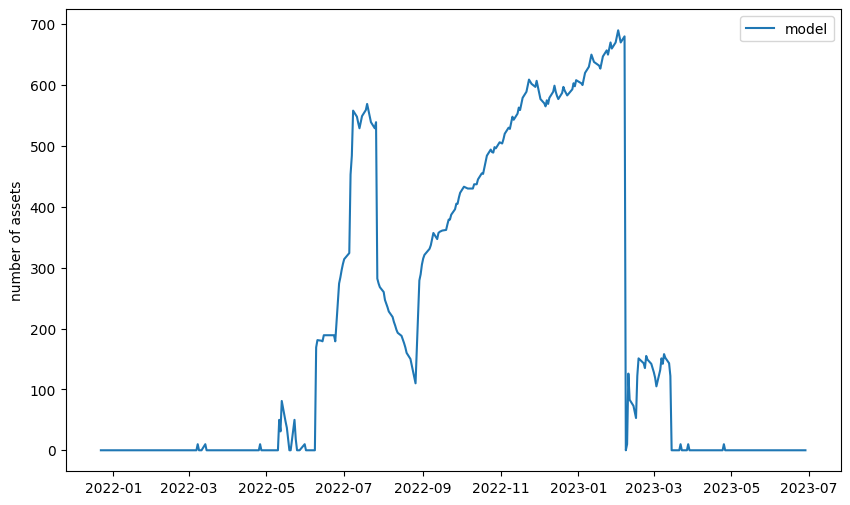

In [16]:

plt.figure(figsize=(10,6))
plt.plot(res.index, res["allocation"], label="model")
plt.ylabel("number of assets")
plt.legend()